### Importing images and files

In [1]:
#Import all the important libraries
import os
import sys
import tkinter as tk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import pandas as pd
import sklearn
import cv2
import cvzone
import mediapipe as mp
import matplotlib.pyplot as plt
import tensorflow as tf
from cvzone.HandTrackingModule import HandDetector
from tensorflow import keras
from keras import layers
from keras.models import Sequential, load_model
from keras import backend as K
from keras.layers.core import Dense, Flatten
from keras import optimizers
#from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *

import itertools
%matplotlib inline

from math import floor
from PIL import Image, ImageTk
import serial
import time

### Taking pictures for the model

In [ ]:
# Start video stream from your computer camera 
capture = cv2.VideoCapture(0) 

# Capture continuous video
i = 1 
while True:
    ret, image = capture.read() # read from the video
    image = cv2.flip(image,1) # flip your video
    
    cv2.rectangle(image,(360,60),(590,290),(0,255,0),5) # draw a green square, the location of two vertexs are (360,60) and (590,290)
    # so the size of picture is 
    font = cv2.FONT_HERSHEY_SIMPLEX # define your font
    cv2.putText(image,'Put your RIGHT hand in the square',(255,40),font,0.7,(0,255,0),1,cv2.LINE_AA) # write green text at start at location (255,40)
    print(image.shape)
    cv2.imshow('Taking data pictures',image)  # display your video on your computer as name 'taking picture'
    k = cv2.waitKey(1) # get input from keyboard
    if k == ord('c'): #press 'c' key to capture photo, and increment 1
        i+=1
        print(i) # print out the counter value
        
        cv2.imwrite('data/train/0/imag'+str(i)+'.jpg',frame[63:287,363:587]) # save your picture with size (224,224) to some location in the same folder
        #remember change to corresponding directory
          
    if k ==27: # press 'Esc' key to exit 
        break # exit while loop
        
#========================================

cv2.destroyAllWindows() # close down window
capture.release() # disable your camera        

### Data Processing and Setup

In [2]:
# Directories for all the data

trainingDirectory = '../SpaceRoverProject/Training'
testingDirectory = '../SpaceRoverProject/Testing'
validationDirectory = '../SpaceRoverProject/Validation'

In [3]:
# Generate batches of tensor image data with real-time data augmentation.

train_batches = ImageDataGenerator().flow_from_directory(trainingDirectory,target_size=(224,224),classes=['Forward','Left','Reverse','Right','Stop'],batch_size=8) 
# target_size: the size of pictures | classes: the file name of your different classes 
test_batches = ImageDataGenerator().flow_from_directory(testingDirectory,target_size=(224,224),classes=['Forward','Left','Reverse','Right','Stop'],batch_size=5)
valid_batches = ImageDataGenerator().flow_from_directory(validationDirectory,target_size=(224,224),classes=['Forward','Left','Reverse','Right','Stop'],batch_size=10)


Found 710 images belonging to 5 classes.
Found 245 images belonging to 5 classes.
Found 242 images belonging to 5 classes.


In [4]:
# Define plots function to show sample images from data

def plots(ims,figsize=(12,6),rows=1,interp=False,titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1]!=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 ==0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i],fontsize=12)
        plt.imshow(ims[i],interpolation=None if interp else 'none')

In [5]:
imgs, labels = next(train_batches) # read the image and corresponding labels which indicate the class

/Users/malharshah/Library/Python/3.8/lib/python/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


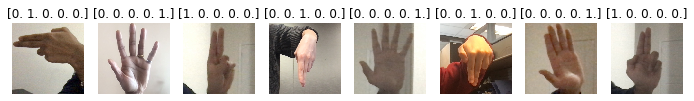

In [6]:
plots(imgs,titles=labels) # the labels are in 'one-hot' format

### Loading vgg19 pretrained model from Keras

In [58]:
vgg19_model = tf.keras.applications.vgg19.VGG19(include_top=True,weights='imagenet')
# automatically download vgg19 model from the website below, which is about 500 MB,
# which may takes 15 mins
# once downloaded, you don't need to download again

In [59]:
# Show the model structure of vgg19

vgg19_model.summary() # contain total 19 layers

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [60]:
type(vgg19_model) # the type of the model

keras.engine.functional.Functional

### Configuring the vgg19 Model

In [61]:
# Changing the model type from "model" to "Sequential"

model = Sequential() #define your own model
for layer in vgg19_model.layers[:-1]: # elimilate the last 'Dense' layer because we don't want 1000 classes, only 5 classes
    model.add(layer)
model.summary() # to see the last layer is gone

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [62]:
for layer in model.layers:
   layer.trainable = False

In [63]:
# Adding a softmax layer at the end to output as one of the 5 classes
model.add(Dense(5,activation='softmax')) # total 5 classes.
model.summary() # to see we've changed the last layer to only output 4 classes

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

### Training the customized model

In [64]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00075), loss='categorical_crossentropy', metrics=['accuracy']) # define loss function and loss optimizer

In [65]:
#steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
steps_per_epoch = len(train_batches)
print(steps_per_epoch)

#validation_steps = total_validation_samples // validation_batch_size
validation_steps = len(valid_batches)
print(validation_steps)

89
25


In [66]:
model.fit(train_batches, steps_per_epoch=steps_per_epoch,validation_data=valid_batches,validation_steps=validation_steps,epochs=3,verbose=2) # train process
# train your model using all 'train' pictures, and test it with all 'valid' pictures, so you can see there are two 'acc' below

Epoch 1/3
89/89 - 132s - loss: 0.3515 - accuracy: 0.8789 - val_loss: 0.0903 - val_accuracy: 0.9793 - 132s/epoch - 1s/step
Epoch 2/3
89/89 - 133s - loss: 0.0196 - accuracy: 0.9972 - val_loss: 0.0916 - val_accuracy: 0.9711 - 133s/epoch - 1s/step
Epoch 3/3
89/89 - 135s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9876 - 135s/epoch - 2s/step


### Using the trained model on testing data

/Users/malharshah/Library/Python/3.8/lib/python/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


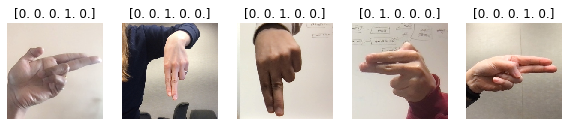

In [67]:
test_imgs,test_labels = next(test_batches) # show some test pictures
plots(test_imgs,titles=test_labels)

In [68]:
predictions = model.predict(test_batches,steps=5,verbose=0) # predict the class of each picture

In [69]:
predictions 
# print out the predicted label value, also in 'one-hot' format
# compare the prediction with the true label of pictures, you can see they are very close

array([[2.30013624e-01, 3.08254559e-04, 2.58847256e-04, 4.03437807e-05,
        7.69378960e-01],
       [4.99410719e-01, 6.71279877e-02, 3.55289690e-02, 8.79549328e-03,
        3.89136791e-01],
       [1.01450769e-05, 1.35197911e-06, 3.08362792e-06, 1.04531200e-05,
        9.99974966e-01],
       [1.28567219e-03, 1.74653751e-03, 2.44182185e-04, 9.96719539e-01,
        4.05852688e-06],
       [1.10164843e-03, 7.72221210e-06, 7.59168006e-06, 2.64709088e-04,
        9.98618364e-01],
       [9.99335349e-01, 4.03311533e-05, 2.08686452e-05, 4.73774271e-04,
        1.29733715e-04],
       [5.03196614e-04, 2.85314309e-04, 1.87886799e-05, 9.99191105e-01,
        1.65120480e-06],
       [1.06592877e-02, 3.38986237e-03, 9.84532058e-01, 1.30176102e-03,
        1.16963573e-04],
       [5.09105250e-03, 9.61691380e-01, 1.79853681e-02, 1.13835270e-02,
        3.84871382e-03],
       [9.04744525e-07, 9.94089484e-01, 8.68986081e-06, 5.81987947e-03,
        8.11020946e-05],
       [4.37663373e-04, 7.4044

In [70]:
for i, prediction in enumerate(predictions):
  if max(prediction) == prediction[0]:
    print("The image prediction of image " + str(i) + " is: Go Forward")
  if max(prediction) == prediction[1]:
    print("The image prediction of image " + str(i) + " is: Turn Left")
  if max(prediction) == prediction[2]:
    print("The image prediction of image " + str(i) + " is: Reverse")
  if max(prediction) == prediction[3]:
    print("The image prediction of image " + str(i) + " is: Turn Right")
  if max(prediction) == prediction[4]:
    print("The image prediction of image " + str(i) + " is: Stop Moving")

The image prediction of image 0 is: Stop Moving
The image prediction of image 1 is: Go Forward
The image prediction of image 2 is: Stop Moving
The image prediction of image 3 is: Turn Right
The image prediction of image 4 is: Stop Moving
The image prediction of image 5 is: Go Forward
The image prediction of image 6 is: Turn Right
The image prediction of image 7 is: Reverse
The image prediction of image 8 is: Turn Left
The image prediction of image 9 is: Turn Left
The image prediction of image 10 is: Turn Right
The image prediction of image 11 is: Stop Moving
The image prediction of image 12 is: Reverse
The image prediction of image 13 is: Turn Right
The image prediction of image 14 is: Reverse
The image prediction of image 15 is: Turn Right
The image prediction of image 16 is: Reverse
The image prediction of image 17 is: Reverse
The image prediction of image 18 is: Turn Left
The image prediction of image 19 is: Turn Right
The image prediction of image 20 is: Go Forward
The image predic

In [71]:
#Get test accuracy
score = model.evaluate(test_batches, verbose=2) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]) 

49/49 - 35s - loss: 0.0598 - accuracy: 0.9878 - 35s/epoch - 708ms/step
Test loss: 0.05981171131134033
Test accuracy: 0.9877551198005676


### Save your trained model

In [72]:
model.save('model.second')

INFO:tensorflow:Assets written to: model.second/assets


### Load your trained model

In [73]:
model = load_model('model.second')

### User Interface

In [75]:
#Fixed image dimensions
width = 224
height = 224
dim = (width, height)

# Set up for fps counter
fpsCounter = cvzone.FPS()

# Start video stream from your computer camera
capture = cv2.VideoCapture(0) 

# Using cvzone library to detect and track the hand
detector = HandDetector(detectionCon=0.8, minTrackCon=0.8, maxHands=2)

# Capture continuous video
i = 1 
while True:
    # Get image frame
    ret, image = capture.read() # read from the video

    # Get interruption key from keyboard
    k = cv2.waitKey(1) # get input from keyboard

    # Flip image frame
    cv2image1 = cv2.flip(image,1)
    #cv2image2 = cv2.cvtColor(cv2image1, cv2.COLOR_BGR2RGBA) # convert video to RGB format  
    
    # Show FPS on screen
    fps, img = fpsCounter.update(cv2image1,pos=(50,80),color=(0,255,0),scale=3,thickness=3)

    # Find the hand and its landmarks
    hands = detector.findHands(img, draw=False, flipType=False)

    #print(img)
    
    rightHand = 0

    if hands:
        # Hand 1
        hand1 = hands[0]
        lmList1 = hand1["lmList"]  # List of 21 Landmark points
        bbox1 = hand1["bbox"]  # Bounding box info x,y,w,h
        centerPoint1 = hand1['center']  # center of the hand cx,cy
        handType1 = hand1["type"]  # Handtype Left or Right
        
        if handType1 == "Right":
            rightHand = hand1
            rightbbox = rightHand["bbox"]  # Bounding box info x,y,w,h 
        
        #fingers1 = detector.fingersUp(hand1)

        if len(hands) == 2:
            # Hand 2
            hand2 = hands[1]
            lmList2 = hand2["lmList"]  # List of 21 Landmark points
            bbox2 = hand2["bbox"]  # Bounding box info x,y,w,h
            centerPoint2 = hand2['center']  # center of the hand cx,cy
            handType2 = hand2["type"]  # Hand Type "Left" or "Right"

            if handType2 == "Right":
                rightHand = hand2 
                rightbbox = rightHand["bbox"]  # Bounding box info x,y,w,h 
            
            #fingers2 = detector.fingersUp(hand2)

    
    cv2.rectangle(img,(460,160),(960,660),(0,255,0),5) # draw square
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,'Put your RIGHT hand in the square',(465,140),font,0.8,(0,255,0),2,cv2.LINE_AA) 
    #cv2.putText(cv2image1,'Put your RIGHT hand in this square!',(300,40),font,0.6,(0,255,0),2,cv2.LINE_AA)
    cv2.imshow('Capturing live feed',img)
    #cv2.imshow('Taking data pictures',img)

    if rightHand !=0:
        cv2image = cv2image1[163:657, 463:957] # Take the image within the square
        crop_cv2image = cv2.resize(cv2image, dim, interpolation = cv2.INTER_AREA)
        img = crop_cv2image.reshape((1,)+ crop_cv2image.shape ) #reshape it so that model can accept

        cv2.imshow('The picture 1',cv2image)
        cv2.imshow('The picture 2',crop_cv2image)

        prediction = model.predict(img)[0]    
        
        pred_class = list(prediction).index(max(prediction))

        rightHandFingers = detector.fingersUp(rightHand)

        #if rightHandFingers[1] and rightHandFingers[2]:
        if max(prediction) > 0.8:
            print(prediction) 
            print(pred_class)
            
            if pred_class==0:
                print('Go Forward')
                #command("fwd_bit")
            elif pred_class==1:
                print('Turn Left')
                #command("left_bit")
            elif pred_class==2:
                print('Reverse')
                #command("left_bit")
            elif pred_class==3:
                print('Turn Right')
                #command("right_bit")
            elif pred_class==4:
                print('Stop Moving')  
                #command("stop")
        # else:
        #     print('Stop Moving')
          
    if k ==27: # press 'Esc' key to exit 
        break # exit while loop
        
#========================================

cv2.destroyAllWindows() # close down window
capture.release() # disable your camera  

[8.4267694e-01 8.5547874e-03 9.0304911e-03 1.3954391e-01 1.9390338e-04]
0
Go Forward
[0.00238338 0.13517465 0.00785785 0.8480503  0.00653388]
3
Turn Right
[0.00157537 0.12287932 0.0224736  0.8394319  0.01363983]
3
Turn Right
[0.00175337 0.07627181 0.03289405 0.87574273 0.01333818]
3
Turn Right
[2.6451580e-03 3.4290012e-02 3.7781745e-02 9.2454833e-01 7.3475175e-04]
3
Turn Right
[2.3548983e-03 7.6766582e-03 2.7182695e-02 9.6236795e-01 4.1783464e-04]
3
Turn Right
[0.00821583 0.02160033 0.07159013 0.89763707 0.00095652]
3
Turn Right
[0.00567194 0.0161178  0.0795614  0.8971774  0.00147143]
3
Turn Right
[5.2833660e-03 9.5983772e-03 6.0294267e-02 9.2402923e-01 7.9469976e-04]
3
Turn Right
[0.00334028 0.01167113 0.06603698 0.9178376  0.00111392]
3
Turn Right
[0.00269984 0.13297182 0.8055911  0.03891506 0.01982231]
2
Reverse
[0.0301873  0.02473557 0.8959796  0.02671736 0.02238014]
2
Reverse
[4.6279153e-04 9.4374630e-04 7.2836981e-04 1.6029922e-03 9.9626213e-01]
4
Stop Moving
[1.8615642e-04 4.217